In [450]:
import pandas as pd
df = pd.read_csv('clean_data.csv')
df.head()

,Unnamed: 0,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition_Partial,FireplaceQu_-1,FireplaceQu_0,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,PoolQC_-1,PoolQC_0,MiscFeature_-1,MiscFeature_2
0,0,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,1,0,0,0,0,1,0,1,0
1,1,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,1,1,0,1,0
2,2,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,1,1,0,1,0
3,3,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,0,0,1,0,1,0
4,4,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,0,1,1,0,1,0


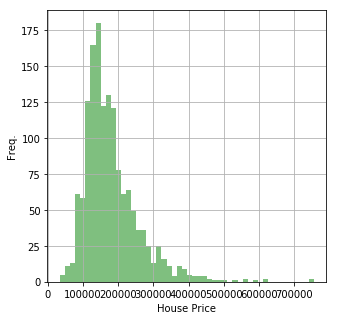

In [451]:
from matplotlib import pyplot as plt

df['SalePrice'].hist(bins=50, facecolor='green', alpha=0.5)
plt.xlabel('House Price')
plt.ylabel('Freq.')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [452]:
df = df.drop(df[df['SalePrice'] > 550000].index)
# df = df.drop(df[df['SalePrice'] <  40000].index)

In [453]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

y = df['SalePrice'].values
x = df.drop(columns=['SalePrice']).values

from sklearn.decomposition import PCA

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [454]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA(n_components=0.99)

pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
x_test_pca = pca.transform(x_test_scaled)

# x_train = x_pca
# x_test = x_test_pca

# x_train = x_scaled
# x_test = x_test_scaled

In [455]:
# Here we make functions in order to evaluate many different classification models

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

def get_houses_eval_metric(y_actual, y_pred):
    total = 0
    for y_a, y_p in zip(y_actual, y_pred):
        total += (np.log(y_a) - np.log(y_p))**2
    return (total/len(y_actual))**(1/2)

# Print out machine learning model metrics
def evaluation(y_actual, y_pred):
    
    r2 = r2_score(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mse**(1/2)
    houses_metric = get_houses_eval_metric(y_actual, y_pred)
    print('R2          : ', round(r2, 4))
    print('RMSE        : ', round(rmse, 2))
    print('HOUSE METRIC: ', round(houses_metric, 2))
    return [r2, mse, rmse, houses_metric]
      
def try_regressor(regressor, name):
    best_mse = np.Inf
    for _ in range(1):
        # Specify that these are global variables
        global x_train, y_train
        global x_test, y_test
        regressor.fit(x_train, y_train)

        if mean_squared_error(y_test, regressor.predict(x_test)) < best_mse:
            print('Evaluation for', name, '\n')
            # Evaluate the test set
            metrics = evaluation(y_test, regressor.predict(x_test))
            best_mse = mean_squared_error(y_test, regressor.predict(x_test))
    print("Best rmse: ", best_mse**(1/2))
    return (metrics + [name])

# Make a list to store model evaluation metrics
regressor_results = list()

In [456]:
rf_regr = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

regressor_results.append(try_regressor(rf_regr, 'Random Forest'))

Evaluation for Random Forest 

R2          :  0.8903
RMSE        :  23935.27
HOUSE METRIC:  0.15
Best rmse:  23935.26754259795


In [457]:
from sklearn.ensemble import AdaBoostRegressor

ada_regr = AdaBoostRegressor()

regressor_results.append(try_regressor(ada_regr, "Ada Boost"))

Evaluation for Ada Boost 

R2          :  0.8265
RMSE        :  30104.28
HOUSE METRIC:  0.2
Best rmse:  30104.277447198263


In [458]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

gb_regr = GradientBoostingRegressor(min_samples_leaf=3, n_estimators=3500, learning_rate=0.01)

regressor_results.append(try_regressor(gb_regr, "Gradient Boosting"))

Evaluation for Gradient Boosting 

R2          :  0.9246
RMSE        :  19850.28
HOUSE METRIC:  0.12
Best rmse:  19850.27894208847


In [459]:
from sklearn.neural_network import MLPRegressor

mlp_regr = MLPRegressor(max_iter=500, hidden_layer_sizes=(200,5), learning_rate='adaptive', solver='lbfgs')

regressor_results.append(try_regressor(mlp_regr, "Neural Network"))

Evaluation for Neural Network 

R2          :  0.7546
RMSE        :  35807.87
HOUSE METRIC:  0.22
Best rmse:  35807.87056799419
